---
title: "Data Analysis"
subtitle: "Comprehensive Data Cleaning & Exploratory Analysis of Job Market Trends"
author:
  - name: Furong Wang
    affiliations:
      - id: bu
        name: Boston University
        city: Boston
        state: MA
  - name: Marco Perez Garcia
    affiliations:
      - ref: bu
bibliography: references.bib
csl: csl/econometrica.csl
format: 
  html:
    toc: true
    number-sections: true
    df-print: paged
---

# **Data Cleaning & Preprocessing**

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

## Dropping Unnecessary Columns

### To simplify our job market analysis, we need to drop columns that are either unnecessary, duplicated, or outdated. 
Specifically, we will remove:  
**1. Older NAICS and SOC codes (e.g., `NAICS2`, `SOC_2`).**
The North American Industry Classification System (NAICS) and Standard Occupational Classification (SOC) systems undergo periodic updates. Retaining only `NAICS_2022_6` and `SOC_2021_4` ensures we use the most recent classification standards. Moreover, older codes are redundant and may lead to inconsistencies in trend analysis.  
**2. Tracking data and URLs (e.g., `ID`, `DUPLICATES`).**
These columns related to data collection timestamps, unique identifiers, or internal system references, which do not contribute to meaningful insights about the job market. Similarly, URLs are not necessary for our analysis as they do not provide any additional value or context but add unnecessary complexity to the dataset.

### Why removing multiple versions of NAICS/SOC codes?
There are some reasons for this. Firstly, keeping only the latest industry and occupation classifications ensures our analysis reflects the most recent classification standards and avoid confusion and inconsistencies in classification. Additionally, reducing unnecessary columns speeds up data processing and enhances readability. This is particularly important when working with large datasets, as it minimizes the risk of errors and improves the efficiency of our analysis. Finally, it helps to focus on the most relevant information, allowing for clearer insights and conclusions regarding job market trends.

### Impact on Analysis:
By removing outdated and irrelevant columns, we achieve:
- More accurate job market trends, focusing on meaningful variables.
- Easier interpretation without clutter from redundant or technical fields.
- Faster analysis and visualization, improving overall efficiency.


In [192]:
job_postings = pd.read_csv('lightcast_job_postings.csv')

In [193]:
columns_to_drop = [
    "ID", "URL", "ACTIVE_URLS", "DUPLICATES", "LAST_UPDATED_TIMESTAMP", "ACTIVE_URLS", "TITLE", "COMPANY",
    "MSA", "STATE", "COUNTY", "CITY", "COUNTY_OUTGOING", "COUNTY_INCOMING", "MSA_OUTGOING", "MSA_INCOMING",
    "ONET", "ONET_2019", "CIP2", "CIP4", "CIP6", "MODELED_DURATION", "MODELED_EXPIRED",
    "CERTIFICATIONS", "COMMON_SKILLS", "SPECIALIZED_SKILLS", "SKILLS", "SOFTWARE_SKILLS",
    "LOT_V6_CAREER_AREA", "LOT_V6_OCCUPATION_GROUP", "LOT_V6_OCCUPATION", "LOT_V6_SPECIALIZED_OCCUPATION",
    "LOT_OCCUPATION_GROUP", "LOT_SPECIALIZED_OCCUPATION", "LOT_OCCUPATION", "LOT_CAREER_AREA",
    "NAICS2", "NAICS2_NAME", "NAICS3", "NAICS3_NAME", "NAICS4", "NAICS4_NAME", "NAICS5", "NAICS5_NAME", "NAICS6",
    "NAICS_2022_2", "NAICS_2022_2_NAME", "NAICS_2022_3", "NAICS_2022_3_NAME", "NAICS_2022_4", "NAICS_2022_4_NAME",
    "NAICS_2022_5", "NAICS_2022_5_NAME", "NAICS_2022_6",
    "SOC_2", "SOC_2_NAME", "SOC_3", "SOC_3_NAME", "SOC_5", "SOC_5_NAME", "SOC_4",
    "SOC_2021_2", "SOC_2021_2_NAME", "SOC_2021_3", "SOC_2021_3_NAME", "SOC_2021_5", "SOC_2021_5_NAME", "SOC_2021_4"
]

job_postings.drop(columns = columns_to_drop, inplace = True)

## Handling Missing Values
### We used different strategies for missing values:

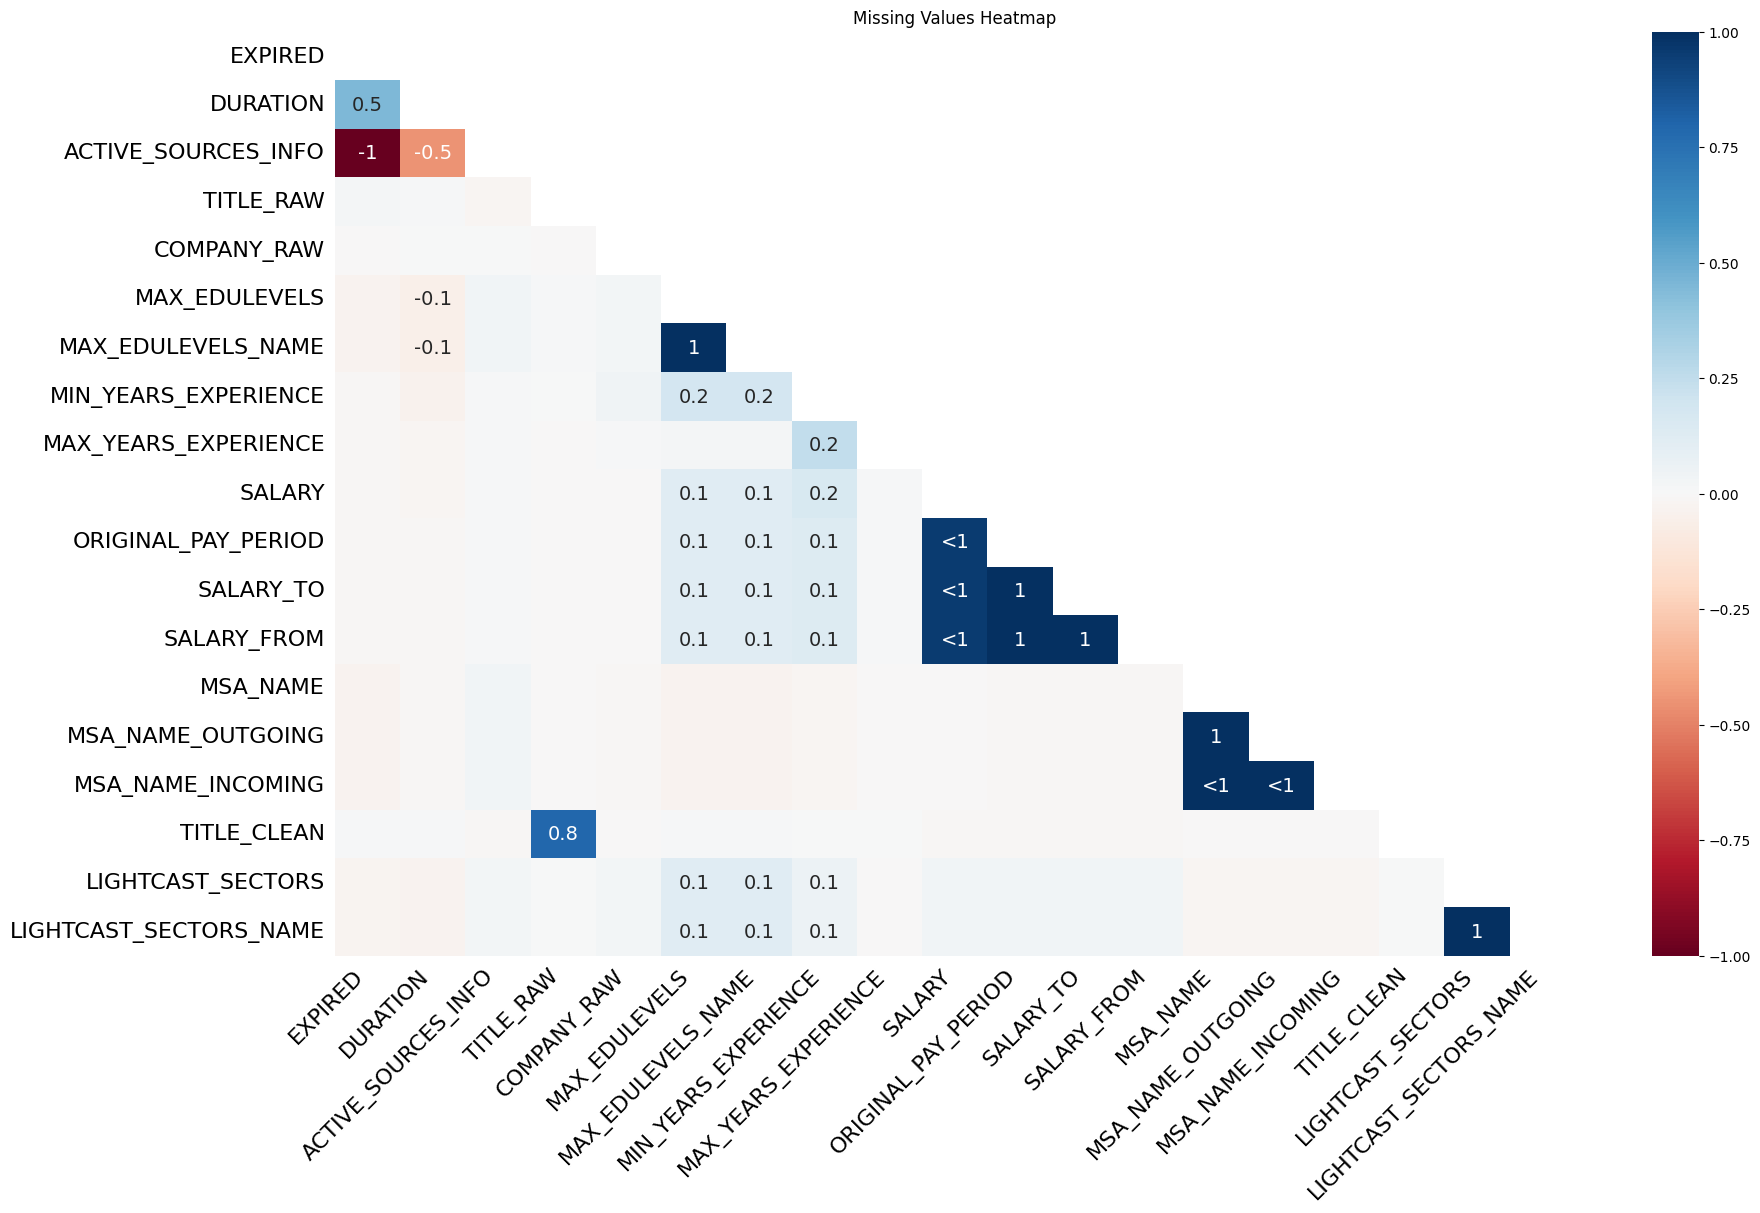

In [194]:
msno.heatmap(job_postings)
plt.title("Missing Values Heatmap")
plt.show()

#### Dealing with the Salary Column
The `SALARY` column has a significant number of missing values. To handle this, we replaced the missing values with the median salary for that specific title or industry. This approach is effective because it minimizes the impact of outliers and provides a more accurate representation of the typical salary for each job title.

In [195]:
title_median_salary = job_postings.groupby('TITLE_NAME')['SALARY'].median()
industry_median_salary = job_postings.groupby('NAICS_2022_6_NAME')['SALARY'].median()

In [196]:
job_postings['SALARY'] = job_postings.apply(
    lambda row: title_median_salary[row['TITLE_NAME']]
    if pd.isna(row['SALARY']) and row['TITLE_NAME'] in title_median_salary else row['SALARY'], 
    axis=1
)

In [197]:
job_postings['SALARY'] = job_postings.apply(
    lambda row: industry_median_salary[row['NAICS_2022_6_NAME']]
    if pd.isna(row['SALARY']) and row['NAICS_2022_6_NAME'] in industry_median_salary else row['SALARY'], 
    axis=1
)

In [198]:
job_postings['SALARY'].fillna(job_postings["SALARY"].median(), inplace = True)

#### Dealing with Columns with >50% missing values
Dealing with columns that have more than 50% missing values is crucial for maintaining the integrity of our dataset. Columns with excessive missing data can introduce bias and reduce the reliability of our analysis. Therefore, we removed any columns that exceed this threshold. This ensures that our dataset remains focused on relevant and reliable information, enhancing the quality of our insights.

In [199]:
job_postings.dropna(thresh = len(job_postings) * 0.5, axis = 1, inplace = True)

#### Dealing with Categorical fields
Categorical fields, such as `TITLE_RAW`, were filled with "Unknown" for missing values. This approach allows us to retain the integrity of the dataset without introducing bias from arbitrary values. By labeling missing categorical data as "Unknown", we can still analyze trends without losing valuable information.

In [200]:
job_postings['TITLE_RAW'].fillna("Unknown", inplace = True)
job_postings['TITLE_CLEAN'].fillna("Unknown", inplace = True)
job_postings['COMPANY_RAW'].fillna("Unknown", inplace = True)
job_postings['MSA_NAME'].fillna("Unknown", inplace = True)
job_postings['MSA_NAME_OUTGOING'].fillna("Unknown", inplace = True)
job_postings['MSA_NAME_INCOMING'].fillna("Unknown", inplace = True)

#### Dealing with Datetime fields
For the `EXPIRED` variable, we chose to fill the missing values with the maximum date from this column. We assumed that the missing value here is because the post has not expired yet. By using the maximum date, we can effectively handle missing values without introducing bias or skewing the results.

In [201]:
job_postings['POSTED'] = pd.to_datetime(job_postings['POSTED'])
job_postings['EXPIRED'] = pd.to_datetime(job_postings['EXPIRED'])

In [202]:
max_expired_date = job_postings['EXPIRED'].max()
job_postings['EXPIRED'] = job_postings['EXPIRED'].fillna(max_expired_date)

#### Dealing with Numerical fields
For the `MIN_YEARS_EXPERIENCE` variable, we chose to fill the missing values with the median `MIN_YEARS_EXPERIENCE` for a specific title or industry, similar to how we did with the `SALARY` variable. This can minimize the impact of outliers and provides a more accurate representation of the typical years of experience required for each job title.

In [203]:
title_median_exp = job_postings.groupby('TITLE_NAME')['MIN_YEARS_EXPERIENCE'].median()
industry_median_exp = job_postings.groupby('NAICS_2022_6_NAME')['MIN_YEARS_EXPERIENCE'].median()

In [204]:
job_postings['MIN_YEARS_EXPERIENCE'] = job_postings.apply(
    lambda row: title_median_exp[row['TITLE_NAME']]
    if pd.isna(row['MIN_YEARS_EXPERIENCE']) and row['TITLE_NAME'] in title_median_exp else row['MIN_YEARS_EXPERIENCE'], 
    axis=1
)

In [205]:
job_postings['MIN_YEARS_EXPERIENCE'] = job_postings.apply(
    lambda row: industry_median_exp[row['NAICS_2022_6_NAME']]
    if pd.isna(row['MIN_YEARS_EXPERIENCE']) and row['NAICS_2022_6_NAME'] in industry_median_exp else row['MIN_YEARS_EXPERIENCE'], 
    axis=1
)

In [206]:
job_postings['MIN_YEARS_EXPERIENCE'].fillna(job_postings["MIN_YEARS_EXPERIENCE"].median(), inplace = True)

`DURATION` variable is also a numerical field, but it has a different approach. We will fill the missing values with the difference between the `POSTED` and `EXPIRED`, which calculates the actual time span based on the available dates.

In [207]:
def impute_duration(cols):
    posted = cols[0]
    expired = cols[1]
    duration = cols[2]

    if pd.isnull(duration):
        return expired - posted
    else: 
        return duration

In [208]:
job_postings['DURATION'] = job_postings[['POSTED', 'EXPIRED', 'DURATION']].apply(impute_duration, axis = 1)

## Removing Duplicate Job Postings

### To ensure each job is counted only once, we removed duplicates based on job title, company, location, and posting date.


In [209]:
job_postings = job_postings.drop_duplicates(subset=["TITLE_NAME", "COMPANY_NAME", "LOCATION", "POSTED"], keep = "first")

# **Exploratory Data Analysis (EDA)**

## Job Postings by Industry

## Salary Distribution by Industry

## Remote vs. On-Site Jobs